In [4]:
import at3d
import numpy as np
import os
import sys
import xarray as xr
from collections import OrderedDict
import pylab as py
path = '/Users/khargenr/AT3D/at3d'

In [5]:
#load the cloud.
cloud_scatterer = at3d.util.load_from_csv(os.path.join(path, './data/synthetic_cloud_fields/jpl_les/rico32x37x26.txt'),
                                           density='lwc',origin=(0.0,0.0))

#load atmosphere
atmosphere = xr.open_dataset(os.path.join(path, './data/ancillary/AFGL_summer_mid_lat.nc'))
#subset the atmosphere
reduced_atmosphere = atmosphere.sel({'z': atmosphere.coords['z'].data[atmosphere.coords['z'].data <= 10.0]})
#merge the atmosphere and cloud z coordinates
#merged_z_coordinate = at3d.grid.combine_z_coordinates([aerosol_scatterer, cloud_scatterer])

#make a merged grid for the rte.
rte_grid = at3d.grid.make_grid(cloud_scatterer.x[1]-cloud_scatterer.x[0],cloud_scatterer.x.size,
                           cloud_scatterer.y[1]-cloud_scatterer.y[0],cloud_scatterer.y.size,
                           cloud_scatterer.z)

In [6]:

# rte_grid = at3d.grid.make_grid(0.1, 10, 0.1, 10, merged_z_coordinate)
#resample the cloud onto the rte_grid
cloud_scatterer_on_rte_grid = at3d.grid.resample_onto_grid(rte_grid, cloud_scatterer)

#define any necessary variables for microphysics here.
#We choose a gamma size distribution and therefore need to define a 'veff' variable.
cloud_scatterer_on_rte_grid['veff'] = (cloud_scatterer_on_rte_grid.reff.dims,
                                       np.full_like(cloud_scatterer_on_rte_grid.reff.data, fill_value=0.1))


# Reconstruction MODIS + MISR

In [7]:
#define sensors.
sensor_resolution = 0.02
sensors_dict = at3d.containers.SensorsDict()
sensor_zenith_list =  [75.0,60.0,45.6,26.1]*2 + [0.0]
sensor_azimuth_list = [90]*4 + [-90]*4 +[0.0]
for zenith,azimuth in zip(sensor_zenith_list, sensor_azimuth_list):
    sensors_dict.add_sensor('MISR',
                    at3d.sensor.orthographic_projection(0.66, 
                                                           rte_grid, 
                                                           sensor_resolution, 
                                                           sensor_resolution,
                                                           azimuth, zenith,
                                                           altitude='TOA', stokes=['I'])
                           )
for wavelength in [1.64, 2.13]:
    sensors_dict.add_sensor('MODIS',
    at3d.sensor.orthographic_projection(wavelength, 
                                           rte_grid, 
                                           sensor_resolution, 
                                           sensor_resolution,
                                           azimuth, zenith,
                                           altitude='TOA', stokes=['I'])
                         )
wavelengths = sensors_dict.get_unique_solvers()
min_stokes = sensors_dict.get_minimum_stokes()

In [8]:
#rayleigh optical properties if desired.
rayleigh_scatterer_list = at3d.rayleigh.to_grid(wavelengths, atmosphere, rte_grid)

In [9]:
solvers = at3d.containers.SolversDict()
cloud_poly_tables = OrderedDict()

for wavelength in wavelengths:
    mie_mono_table = at3d.mie.get_mono_table(
        'Water',(wavelength,wavelength),
        max_integration_radius=65.0,
        minimum_effective_radius=0.1,
        relative_dir='../mie_tables',
        verbose=False
    )
    # print(wavelength)
    # #optical properties from mie calculations.
    # # Cloud
    # water_file = './mie_tables/mie_table_water_SWIR_%d.nc'%(wavelength*1e3)
    # try:
    #     mie_mono_table = xr.load_dataset(water_file)
    # except IOError:
    #     mie_mono_table = at3d.mie.get_mono_table(
    #         'Water', 
    #         (wavelength, wavelength),
    #         minimum_effective_radius=0.1,
    #     )
    #     mie_mono_table.to_netcdf(water_file, mode='w')
    cloud_size_distribution = at3d.size_distribution.get_size_distribution_grid(
        mie_mono_table.radius.data,
        size_distribution_function=at3d.size_distribution.gamma,
        particle_density=1.0,
        reff={'coord_min':.1,'coord_max':30.0,'npoints':30,'spacing':'linear','units':'micron'},
        veff={'coord_min':0.09,'coord_max':0.11,'npoints':2,'spacing':'linear','units':'unitless'},
    )
    poly_table = at3d.mie.get_poly_table(cloud_size_distribution, mie_mono_table)
    cloud_optical_scatterer = at3d.medium.table_to_grid(cloud_scatterer_on_rte_grid, poly_table)
    cloud_poly_tables[wavelength] = poly_table

    # Define solvers
    config = at3d.configuration.get_config()
    config['num_mu_bins'] = 8
    config['num_phi_bins'] = 16
    config['split_accuracy'] = 0.03
    config['spherical_harmonics_accuracy'] = 0 #.001
    config['solution_accuracy'] = 1e-4
    solvers.add_solver(
        wavelength, 
        at3d.solver.RTE(
            numerical_params=config,
            medium={
                'cloud': cloud_optical_scatterer,
                'rayleigh': rayleigh_scatterer_list[wavelength]
            },
            source=at3d.source.solar(wavelength, np.cos(np.deg2rad(60.0)), 0.0, solarflux=1.0),
            surface=at3d.surface.ocean_unpolarized(10.0, 0.0, delx=10.0, dely=10.0),
            num_stokes=min_stokes[wavelength],
            name=None
        )
    )

In [10]:
# get total OD
for wvl in wavelengths:
    sensor_od = sensors_dict['MISR']['sensor_list'][-1]
    solvers[wvl].optical_path(sensor_od)
    print('cloud OD @ %.3f nm ='%wvl, sensor_od.optical_path.data.mean())
    # get Rayleigh OD

cloud OD @ 0.660 nm = 3.301307
cloud OD @ 1.640 nm = 3.3963447
cloud OD @ 2.130 nm = 3.4415367


In [11]:
#very important for the retrieval. the unknowns are visible extinction
#and reff not LWC and Reff. Much more orthogonal.
scaling_factor = cloud_poly_tables[0.66].extinction[:].copy(deep=True).data
#print(scaling_factor)
for wavelength in cloud_poly_tables:
    cloud_poly_tables[wavelength]['extinction'][:] /= scaling_factor

In [12]:
sensors_dict.get_measurements(solvers, n_jobs=8)


  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 1.640 micron]
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 2.130 micron]
     1  -0.607  0.324E+00    30784    16.04  0.251   [Radiance 1.640 micron]
     1  -0.652  0.355E+00    30784    16.04  0.251   [Radiance 0.660 micron]
     1  -0.555  0.272E+00    30784    16.04  0.251   [Radiance 2.130 micron]
     2  -1.110  0.370E+00    30784    16.04  0.251   [Radiance 1.640 micron]
     2  -1.309  0.397E+00    30784    16.04  0.251   [Radiance 0.660 micron]
     2  -1.012  0.321E+00    30784    16.04  0.251   [Radiance 2.130 micron]
     3  -1.482  0.393E+00    30784    16.04  0.251   [Radiance 1.640 micron]
     3  -1.637  0.413E+00    30784    16.04  0.251   [Radiance 0.660 micron]
     3  -1.431  0.349E+00    30784    16.04  0.251   [Radiance 2.130 micron]
     4  -1.718  0.313E+00    30824    16.11  0.252   [Radiance 1.640 micron]
     4  

In [13]:
def retrieve(uncertainty = 6e9, scale = 1.5e2):
    Sensordict = sensors_dict
    uncertainty = at3d.uncertainties.NullUncertainty('L2', uncertainty)#at3d.uncertainties.TandemStereoCamera('L2', camera_to_camera_calibration_uncertainty=0.0,
                #                                      absolute_calibration_uncertainty=0.0)#at3d.uncertainties.RadiometricUncertainty('L2',1e-5, 1e-3)
    Sensordict.add_uncertainty_model('MISR', uncertainty)
    # uncertainty = at3d.uncertainties.RadiometricNoiseUncertainty(0, .001)
    # Sensordict.add_uncertainty_model('MISR', uncertainty)
    # Sensordict.add_noise('MISR')
    # Sensordict.add_uncertainty_model('MODIS', uncertainty)
    # Sensordict.add_noise('MODIS')
    forward_sensors = Sensordict.make_forward_sensors() # make a perfect copy of the sensor with the same subpixel rays.

    scale_reff = scale
    #scale_aerosol_density = 1e4

    wavelengths = forward_sensors.get_unique_solvers()

    mask = solvers[0.66].medium['cloud'].extinction.data > 0.0

    ext_profile = np.sum(solvers[0.66].medium['cloud'].extinction.data, axis=(0,1))
    CBH = rte_grid.z.data[np.where(ext_profile>0)[0][0]]
    CTH = rte_grid.z.data[np.where(ext_profile>0)[0][-1]]
    print(CBH, CTH)
    initial_cloud = xr.Dataset(
        data_vars={
            'density':(['x','y','z'], np.ones((rte_grid.x.size, rte_grid.y.size, rte_grid.z.size))),
            'reff': (['x','y','z'], np.zeros((rte_grid.x.size, rte_grid.y.size, rte_grid.z.size))+10.0),
            'veff':(['x','y','z'] ,np.zeros((rte_grid.x.size, rte_grid.y.size, rte_grid.z.size))+0.1)
        },
        coords=rte_grid.coords
    )

    #resample the cloud onto the rte_grid
    initial_cloud_on_grid = at3d.grid.resample_onto_grid(rte_grid, cloud_scatterer_on_rte_grid.copy(deep=True))
    reff_profile_true = np.nanmean(cloud_scatterer.reff.data, axis=(0,1))

    def state_to_grid_density_cloud(state):
        state_on_grid = np.zeros((rte_grid.x.size, rte_grid.y.size, rte_grid.z.size))
        state_on_grid[mask] = state[1:]
        return state_on_grid

    def state_to_grid_reff_cloud(state):
        state_on_grid = np.zeros((rte_grid.x.size, rte_grid.y.size, rte_grid.z.size))
        state_on_grid[:,:,:] = state[0]*(rte_grid.z.data-0.44)**(1.0/3)/scale_reff #+state[1]/scale3
        state_on_grid[np.where(state_on_grid < 4.1)] = 4.1
        state_on_grid[np.where(np.isnan(state_on_grid))] = 4.1
        return state_on_grid

    solvers_reconstruct = at3d.containers.SolversDict()
    rayleigh_scatterer_list = at3d.rayleigh.to_grid(wavelengths,atmosphere,rte_grid)

    def set_state_fn(state):

        #update microphysics
        #aerosol_scatterer_on_rte_grid = initial_aerosol_on_grid.copy(deep=True)
        cloud_scatterer_on_rte_grid = initial_cloud_on_grid.copy(deep=True)

        cloud_scatterer_on_rte_grid['density'][:] = state_to_grid_density_cloud(state)
        cloud_scatterer_on_rte_grid['reff'][:] = state_to_grid_reff_cloud(state)
        #update optical properties
        for wavelength in wavelengths:
            poly_table = cloud_poly_tables[wavelength] #tables are used here.
            cloud_optical_scatterer = at3d.medium.table_to_grid(cloud_scatterer_on_rte_grid, poly_table)
            #cloud_optical_scatterer['extinction'][:] = state_to_grid_ext_cloud(state)
            
            #aerosol_poly_table = aerosol_poly_tables[wavelength]
            #aerosol_optical_scatterer = at3d.medium.table_to_grid(aerosol_scatterer_on_rte_grid, aerosol_poly_table)
            #aerosol_optical_scatterer['extinction'][:] = state_to_grid_ext_aerosol(state)      

    #         config = at3d.configuration.get_config('./default_config.json')
    #         config['num_mu_bins'] = 2
    #         config['num_phi_bins'] = 4
    #         config['split_accuracy'] = 0.1
    #         config['spherical_harmonics_accuracy'] = 0.001
    #         config['solution_accuracy'] = 1e-5
            solvers_reconstruct.add_solver(wavelength, at3d.solver.RTE(#numerical_params=config,
                                    numerical_params=solvers[wavelength].numerical_params,#config,
                                                    medium={'cloud': cloud_optical_scatterer,
                                                        'rayleigh': rayleigh_scatterer_list[wavelength]
                                                        },
                                                    source=solvers[wavelength].source,
                                                    surface=solvers[wavelength].surface,
                                                    num_stokes=solvers[wavelength]._nstokes,
                                                    name=None
                                                    )
                                    )

    # unknown_scatterers = at3d.containers.UnknownScatterers()
    # unknown_scatterers.add_unknown('cloud', ['density','reff'], cloud_poly_tables)
    # unknown_scatterers.create_derivative_tables()

    mie_mono_tables = OrderedDict()
    for wavelength in wavelengths:
        mie_mono_tables[wavelength] = at3d.mie.get_mono_table(
            'Water',(wavelength,wavelength),
            max_integration_radius=65.0,
            minimum_effective_radius=0.1,
            relative_dir='../mie_tables',
            verbose=False
        )

    optical_property_generator = at3d.medium.OpticalPropertyGenerator(
        'cloud', 
        mie_mono_tables,
        at3d.size_distribution.gamma,
        density_normalization='geometric_extinction',
        reff=np.linspace(.1,30.0,30),
        veff=np.linspace(0.03,0.2,9),
    )

    # We are using the ground_truth rte_grid.
    grid_to_optical_properties = at3d.medium.MicrophysicsGridToOpticalProperties(
        rte_grid, optical_property_generator, cloud_optical_scatterer
    )

    # UnknownScatterers is a container for all of the unknown variables.
    # Each unknown_scatterer also records the transforms from the abstract state vector
    # to the gridded data in physical coordinates.
    unknown_scatterers = at3d.containers.UnknownScatterers(
        at3d.medium.UnknownScatterer(grid_to_optical_properties,
            reff=(at3d.transforms.CoordinateTransformScaling(0, 1), at3d.transforms.StateToGridProfile(mask=mask)),
            density=(at3d.transforms.CoordinateTransformScaling(0, 1), at3d.transforms.StateToGridMask(mask=mask))
        #reff=(at3d.transforms.CoordinateTransform(), at3d.transforms.StateToGridProfile(mask=carved_volume.mask.data))
        )
    )

    def project_gradient_to_state(state, gradient):
        cloud_gradient = gradient.gradient.sel(variable_name='density',
                                            scatterer_name='cloud').data[mask]

        reff_gradient = gradient.gradient.sel(variable_name='reff',
                                            scatterer_name='cloud').where(mask, np.nan)
        
        reff_gradient1 = np.nansum(reff_gradient, axis=(0,1))*(rte_grid.z.data - 0.44)**(1.0/3)
        #reff_gradient2 = np.nansum(reff_gradient,axis=(0,1))

        full_grad = np.append(np.nansum(reff_gradient1)/scale_reff, cloud_gradient)
        
        #print some things here because I'm lazy.
        print('reff', state[0]/scale_reff , full_grad[0])
        print('cloud density avg.', np.mean(state[1:]), np.mean(full_grad[1:]))
        print('reff profile retrieve', state_to_grid_reff_cloud(state).mean(axis=(0,1)))
        print('reff profile true', reff_profile_true)
        return full_grad

    min_bound = np.zeros(1+np.sum(mask))+1e-5
    min_bound[0] = 1e-4*scale_reff

    max_bound = np.zeros(1+np.sum(mask))+199
    max_bound[0] = 29.9*scale_reff

    obj_fun = at3d.optimize.ObjectiveFunction.LevisApproxUncorrelatedL2(
        Sensordict, 
        solvers_reconstruct,
        forward_sensors,
        unknown_scatterers,
        set_state_fn,
        project_gradient_to_state,
        #exact_single_scatter=False,
        parallel_solve_kwargs={'n_jobs': 4, 'mpi_comm':None,
                                    'verbose':False, 'maxiter':100, 'init_solution':True},
        gradient_kwargs={'cost_function': 'L2', 'exact_single_scatter':False},
        uncertainty_kwargs={'add_noise': False},
        min_bounds=min_bound,
        max_bounds=max_bound
    )

    # initial guess
    x0_reff = 10
    x0_ext_cloud = 10
    x0 = np.append(np.array([x0_reff*scale_reff]), x0_ext_cloud*np.ones(np.sum(mask)))
    print(x0)
    print(state_to_grid_reff_cloud(x0).mean(axis=(0,1)))
    optimizer = at3d.optimize.Optimizer
    optimizer = at3d.optimize.Optimizer
    optimizer.options

    #define optimizer (no prior function)
    optimizer = at3d.optimize.Optimizer(obj_fun)#, prior_fn=prior_func)
    optimizer._options['maxls'] = 8
    optimizer._options['maxiter'] = 20 #maxiter to 1 to debug the saving of result.
    #optimize for the specified initial condition.
    result = optimizer.minimize(x0)
    return solvers_reconstruct[.66].medium['cloud'].reff.data.max(), np.nanmean(solvers_reconstruct[.66].medium['cloud'].density.data[mask])

In [14]:
uncertainties = np.exp(np.arange(-1, .1, .5))*4144405980.0
print(uncertainties)
scales = np.exp(np.arange(-.5, 1.5, .5))*9
print(scales)

[1.52464176e+09 2.51370929e+09 4.14440598e+09]
[ 5.45877594  9.         14.83849144 24.46453646]


1 out of 12
------uncertainty 1524641755.9099839 scale 5.458775937413701 -------
0.56 1.4


/var/folders/tq/1q0g78nx5zg1y2kq5s69xgz80000gq/T/ipykernel_82541/956757203.py:35: RuntimeWarning: Mean of empty slice
  reff_profile_true = np.nanmean(cloud_scatterer.reff.data, axis=(0,1))
/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/gradient.py:110: UserWarning: No uncertainty model supplied for instrument 'MODIS'. Using at3d.uncertainties.NullUncertainty which isequivalent to unweighted least squares.
  warnings.warn(


[54.58775937 10.         10.         ... 10.         10.
 10.        ]
[ 4.1         4.1         4.30886938  4.93242415  5.42883523  5.84803548
  6.21446501  6.54213262  6.83990379  7.11378661  7.368063    7.60590492
  7.82973528  8.04145152  8.2425706   8.43432665  8.61773876  8.79365934
  8.96280949  9.12580527  9.28317767  9.43538796  9.58283971  9.72588826
  9.8648483  10.        ]
reff 10.0 1220.4788521881987
cloud density avg. 10.0 -5.830682496913156
reff profile retrieve [ 4.1         4.1         4.30886938  4.93242415  5.42883523  5.84803548
  6.21446501  6.54213262  6.83990379  7.11378661  7.368063    7.60590492
  7.82973528  8.04145152  8.2425706   8.43432665  8.61773876  8.79365934
  8.96280949  9.12580527  9.28317767  9.43538796  9.58283971  9.72588826
  9.8648483  10.        ]
reff profile true [   nan    nan    nan 11.685 12.521 13.314 14.001 14.607 15.106 15.532
 15.904 16.321 16.756 17.022 17.261 17.425 17.593 17.794 17.99  18.176
 18.325 18.425 18.506 18.573 18.698    


 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
/var/folders/tq/1q0g78nx5zg1y2kq5s69xgz80000gq/T/ipykernel_82541/956757203.py:35: RuntimeWarning: Mean of empty slice
  reff_profile_true = np.nanmean(cloud_scatterer.reff.data, axis=(0,1))


[90. 10. 10. ... 10. 10. 10.]
[ 4.1         4.1         4.30886938  4.93242415  5.42883523  5.84803548
  6.21446501  6.54213262  6.83990379  7.11378661  7.368063    7.60590492
  7.82973528  8.04145152  8.2425706   8.43432665  8.61773876  8.79365934
  8.96280949  9.12580527  9.28317767  9.43538796  9.58283971  9.72588826
  9.8648483  10.        ]
reff 10.0 740.2578433830258
cloud density avg. 10.0 -5.830682496913156
reff profile retrieve [ 4.1         4.1         4.30886938  4.93242415  5.42883523  5.84803548
  6.21446501  6.54213262  6.83990379  7.11378661  7.368063    7.60590492
  7.82973528  8.04145152  8.2425706   8.43432665  8.61773876  8.79365934
  8.96280949  9.12580527  9.28317767  9.43538796  9.58283971  9.72588826
  9.8648483  10.        ]
reff profile true [   nan    nan    nan 11.685 12.521 13.314 14.001 14.607 15.106 15.532
 15.904 16.321 16.756 17.022 17.261 17.425 17.593 17.794 17.99  18.176
 18.325 18.425 18.506 18.573 18.698    nan]
RUNNING THE L-BFGS-B CODE

          


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.


reff 11.940632715050675 117.20777485755146
cloud density avg. 19.18519206117995 -0.5928134860138851
reff profile retrieve [ 4.1         4.1         5.14506267  5.88962652  6.48237276  6.98292437
  7.42046442  7.81172028  8.16727789  8.49431131  8.79793341  9.08193171
  9.34919933  9.60200191  9.84215082 10.07111968 10.29012534 10.50018565
 10.70216163 10.8967889  11.0847015  11.26645022 11.44251694 11.61332596
 11.77925303 11.94063272]
reff profile true [   nan    nan    nan 11.685 12.521 13.314 14.001 14.607 15.106 15.532
 15.904 16.321 16.756 17.022 17.261 17.425 17.593 17.794 17.99  18.176
 18.325 18.425 18.506 18.573 18.698    nan]
reff 1.2759455131160289 -103.7833648817183
cloud density avg. 19.235284130175284 0.058734095880769374
reff profile retrieve [4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1
 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1]
reff profile true [   nan    nan    nan 11.685 12.521 13.314 14.001 14.607 15.106 15.532
 15.904 16.321 16.756 17.022 17.261 


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.


reff 9.053828293248252 125.44892957610799
cloud density avg. 19.17760523531732 nan
reff profile retrieve [4.1        4.1        4.1        4.46573213 4.9151742  5.29471091
 5.62646992 5.92313454 6.19273144 6.44070025 6.67091772 6.88625572
 7.08890788 7.28059213 7.46268189 7.63629453 7.8023527  7.96162818
 8.11477382 8.2623474  8.40482966 8.54263825 8.67613853 8.80565223
 8.93146426 9.05382829]
reff profile true [   nan    nan    nan 11.685 12.521 13.314 14.001 14.607 15.106 15.532
 15.904 16.321 16.756 17.022 17.261 17.425 17.593 17.794 17.99  18.176
 18.325 18.425 18.506 18.573 18.698    nan]
reff 5.369316662701992 -33.160604806756304
cloud density avg. 19.216057553139684 0.038555889327900134
reff profile retrieve [4.1        4.1        4.1        4.1        4.1        4.1
 4.1        4.1        4.1        4.1        4.1        4.1
 4.20403281 4.31770996 4.42569717 4.52865706 4.62713683 4.72159416
 4.81241624 4.89993383 4.98443205 5.06615858 5.1453301  5.22213739
 5.29674943 5.3693166

/var/folders/tq/1q0g78nx5zg1y2kq5s69xgz80000gq/T/ipykernel_82541/956757203.py:35: RuntimeWarning: Mean of empty slice
  reff_profile_true = np.nanmean(cloud_scatterer.reff.data, axis=(0,1))


[148.38491436  10.          10.         ...  10.          10.
  10.        ]
[ 4.1         4.1         4.30886938  4.93242415  5.42883523  5.84803548
  6.21446501  6.54213262  6.83990379  7.11378661  7.368063    7.60590492
  7.82973528  8.04145152  8.2425706   8.43432665  8.61773876  8.79365934
  8.96280949  9.12580527  9.28317767  9.43538796  9.58283971  9.72588826
  9.8648483  10.        ]
reff 10.0 448.9890781045579
cloud density avg. 10.0 -5.830682496913156
reff profile retrieve [ 4.1         4.1         4.30886938  4.93242415  5.42883523  5.84803548
  6.21446501  6.54213262  6.83990379  7.11378661  7.368063    7.60590492
  7.82973528  8.04145152  8.2425706   8.43432665  8.61773876  8.79365934
  8.96280949  9.12580527  9.28317767  9.43538796  9.58283971  9.72588826
  9.8648483  10.        ]
reff profile true [   nan    nan    nan 11.685 12.521 13.314 14.001 14.607 15.106 15.532
 15.904 16.321 16.756 17.022 17.261 17.425 17.593 17.794 17.99  18.176
 18.325 18.425 18.506 18.573 18.69


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.


reff 5.516310651515623 -14.090290429074408
cloud density avg. 19.388811230231887 0.039107154339973416
reff profile retrieve [4.1        4.1        4.1        4.1        4.1        4.1
 4.1        4.1        4.1        4.1        4.1        4.19565343
 4.31912521 4.43591447 4.546858   4.6526366  4.75381241 4.85085567
 4.94416415 5.03407768 5.12088918 5.20485311 5.28619208 5.3651021
 5.44175677 5.51631065]
reff profile true [   nan    nan    nan 11.685 12.521 13.314 14.001 14.607 15.106 15.532
 15.904 16.321 16.756 17.022 17.261 17.425 17.593 17.794 17.99  18.176
 18.325 18.425 18.506 18.573 18.698    nan]

At iterate    8    f=  6.38806D+03    |proj g|=  1.40903D+01
reff 7.039847184077695 48.22023066254338
cloud density avg. 19.32707292586889 nan
reff profile retrieve [4.1        4.1        4.1        4.1        4.1        4.11692761
 4.3748884  4.60556139 4.81518774 5.00799706 5.18700375 5.35444083
 5.51201399 5.66105898 5.80264374 5.93763707 6.06675639 6.1906018
 6.30968092 6.42442745

/var/folders/tq/1q0g78nx5zg1y2kq5s69xgz80000gq/T/ipykernel_82541/956757203.py:35: RuntimeWarning: Mean of empty slice
  reff_profile_true = np.nanmean(cloud_scatterer.reff.data, axis=(0,1))


[244.64536456  10.          10.         ...  10.          10.
  10.        ]
[ 4.1         4.1         4.30886938  4.93242415  5.42883523  5.84803548
  6.21446501  6.54213262  6.83990379  7.11378661  7.368063    7.60590492
  7.82973528  8.04145152  8.2425706   8.43432665  8.61773876  8.79365934
  8.96280949  9.12580527  9.28317767  9.43538796  9.58283971  9.72588826
  9.8648483  10.        ]
reff 10.0 272.32564174652464
cloud density avg. 10.0 -5.830682496913156
reff profile retrieve [ 4.1         4.1         4.30886938  4.93242415  5.42883523  5.84803548
  6.21446501  6.54213262  6.83990379  7.11378661  7.368063    7.60590492
  7.82973528  8.04145152  8.2425706   8.43432665  8.61773876  8.79365934
  8.96280949  9.12580527  9.28317767  9.43538796  9.58283971  9.72588826
  9.8648483  10.        ]
reff profile true [   nan    nan    nan 11.685 12.521 13.314 14.001 14.607 15.106 15.532
 15.904 16.321 16.756 17.022 17.261 17.425 17.593 17.794 17.99  18.176
 18.325 18.425 18.506 18.573 18.6


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.


reff 1.667654722425534 -26.832718916725515
cloud density avg. 19.30040981651403 0.07548419159547612
reff profile retrieve [4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1
 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1]
reff profile true [   nan    nan    nan 11.685 12.521 13.314 14.001 14.607 15.106 15.532
 15.904 16.321 16.756 17.022 17.261 17.425 17.593 17.794 17.99  18.176
 18.325 18.425 18.506 18.573 18.698    nan]

At iterate    8    f=  4.91307D+03    |proj g|=  2.68327D+01
reff 5.791706268055871 27.352024643878863
cloud density avg. 18.982428667601937 -0.07035285271497005
reff profile retrieve [4.1        4.1        4.1        4.1        4.1        4.1
 4.1        4.1        4.1        4.12009625 4.26736566 4.40511672
 4.53475269 4.65737252 4.77385478 4.88491425 4.99114116 5.09302919
 5.19099599 5.28539836 5.37654383 5.46469956 5.55009928 5.6329488
 5.71343037 5.79170627]
reff profile true [   nan    nan    nan 11.685 12.521 13.314 14.001 14.607 15.106 15.532
 15.904 1


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.


reff 2.7379394406220676 8.629428981321754
cloud density avg. 19.13163695388437 nan
reff profile retrieve [4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1
 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1]
reff profile true [   nan    nan    nan 11.685 12.521 13.314 14.001 14.607 15.106 15.532
 15.904 16.321 16.756 17.022 17.261 17.425 17.593 17.794 17.99  18.176
 18.325 18.425 18.506 18.573 18.698    nan]

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
 3944     14     47     80     0    39   9.370D+00   1.927D+03
  F =   1926.8033568905319     

ABNORMAL_TERMINATION_IN_LNSRCH                              
5 out o


 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
/var/folders/tq/1q0g78nx5zg1y2kq5s69xgz80000gq/T/ipykernel_82541/956757203.py:35: RuntimeWarning: Mean of empty slice
  reff_profile_true = np.nanmean(cloud_scatterer.reff.data, axis=(0,1))


[54.58775937 10.         10.         ... 10.         10.
 10.        ]
[ 4.1         4.1         4.30886938  4.93242415  5.42883523  5.84803548
  6.21446501  6.54213262  6.83990379  7.11378661  7.368063    7.60590492
  7.82973528  8.04145152  8.2425706   8.43432665  8.61773876  8.79365934
  8.96280949  9.12580527  9.28317767  9.43538796  9.58283971  9.72588826
  9.8648483  10.        ]
reff 10.0 2012.2294440115159
cloud density avg. 10.0 -9.61317025529219
reff profile retrieve [ 4.1         4.1         4.30886938  4.93242415  5.42883523  5.84803548
  6.21446501  6.54213262  6.83990379  7.11378661  7.368063    7.60590492
  7.82973528  8.04145152  8.2425706   8.43432665  8.61773876  8.79365934
  8.96280949  9.12580527  9.28317767  9.43538796  9.58283971  9.72588826
  9.8648483  10.        ]
reff profile true [   nan    nan    nan 11.685 12.521 13.314 14.001 14.607 15.106 15.532
 15.904 16.321 16.756 17.022 17.261 17.425 17.593 17.794 17.99  18.176
 18.325 18.425 18.506 18.573 18.698    n


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.


reff 29.899999999999995 16.049449958670344
cloud density avg. 24.05520942648489 -0.19281671332910727
reff profile retrieve [ 4.1        10.22565616 12.88351945 14.7479482  16.23221735 17.48562607
 18.58125039 19.56097653 20.45131232 21.27022196 22.03050836 22.74165572
 23.41090849 24.04394004 24.64528609 25.21863669 25.76703889 26.29304144
 26.79880038 27.28615776 27.75670123 28.21181    28.65269075 29.0804059
 29.49589641 29.9       ]
reff profile true [   nan    nan    nan 11.685 12.521 13.314 14.001 14.607 15.106 15.532
 15.904 16.321 16.756 17.022 17.261 17.425 17.593 17.794 17.99  18.176
 18.325 18.425 18.506 18.573 18.698    nan]
reff 24.771643231566678 13.979010620921626
cloud density avg. 24.070012186984535 -0.11926000344418518
reff profile retrieve [ 4.1         8.47178282 10.6737775  12.21842513 13.44811696 14.48654484
 15.39425102 16.20593752 16.94356563 17.62201839 18.25190279 18.84107632
 19.3955409  19.9199968  20.41820182 20.89321307 21.347555   21.7833392
 22.20235191 2


 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
/var/folders/tq/1q0g78nx5zg1y2kq5s69xgz80000gq/T/ipykernel_82541/956757203.py:35: RuntimeWarning: Mean of empty slice
  reff_profile_true = np.nanmean(cloud_scatterer.reff.data, axis=(0,1))


[90. 10. 10. ... 10. 10. 10.]
[ 4.1         4.1         4.30886938  4.93242415  5.42883523  5.84803548
  6.21446501  6.54213262  6.83990379  7.11378661  7.368063    7.60590492
  7.82973528  8.04145152  8.2425706   8.43432665  8.61773876  8.79365934
  8.96280949  9.12580527  9.28317767  9.43538796  9.58283971  9.72588826
  9.8648483  10.        ]
reff 10.0 1220.4788521694902
cloud density avg. 10.0 -9.61317025529219
reff profile retrieve [ 4.1         4.1         4.30886938  4.93242415  5.42883523  5.84803548
  6.21446501  6.54213262  6.83990379  7.11378661  7.368063    7.60590492
  7.82973528  8.04145152  8.2425706   8.43432665  8.61773876  8.79365934
  8.96280949  9.12580527  9.28317767  9.43538796  9.58283971  9.72588826
  9.8648483  10.        ]
reff profile true [   nan    nan    nan 11.685 12.521 13.314 14.001 14.607 15.106 15.532
 15.904 16.321 16.756 17.022 17.261 17.425 17.593 17.794 17.99  18.176
 18.325 18.425 18.506 18.573 18.698    nan]
RUNNING THE L-BFGS-B CODE

          


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.


reff 29.899999999999995 12.137921951283268
cloud density avg. 23.9460075003325 -0.25950874467547713
reff profile retrieve [ 4.1        10.22565616 12.88351945 14.7479482  16.23221735 17.48562607
 18.58125039 19.56097653 20.45131232 21.27022196 22.03050836 22.74165572
 23.41090849 24.04394004 24.64528609 25.21863669 25.76703889 26.29304144
 26.79880038 27.28615776 27.75670123 28.21181    28.65269075 29.0804059
 29.49589641 29.9       ]
reff profile true [   nan    nan    nan 11.685 12.521 13.314 14.001 14.607 15.106 15.532
 15.904 16.321 16.756 17.022 17.261 17.425 17.593 17.794 17.99  18.176
 18.325 18.425 18.506 18.573 18.698    nan]
reff 22.49511859000224 7.502343240220305
cloud density avg. 24.003972049101762 -0.09201972607892017
reff profile retrieve [ 4.1         7.69322234  9.69285277 11.09554662 12.21222924 13.15522516
 13.97951274 14.71660491 15.38644468 16.00254734 16.57454509 17.10957332
 17.61308237 18.08934055 18.54176031 18.97311783 19.38570554 19.78144098
 20.16194624 20.


 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
/var/folders/tq/1q0g78nx5zg1y2kq5s69xgz80000gq/T/ipykernel_82541/956757203.py:35: RuntimeWarning: Mean of empty slice
  reff_profile_true = np.nanmean(cloud_scatterer.reff.data, axis=(0,1))


[148.38491436  10.          10.         ...  10.          10.
  10.        ]
[ 4.1         4.1         4.30886938  4.93242415  5.42883523  5.84803548
  6.21446501  6.54213262  6.83990379  7.11378661  7.368063    7.60590492
  7.82973528  8.04145152  8.2425706   8.43432665  8.61773876  8.79365934
  8.96280949  9.12580527  9.28317767  9.43538796  9.58283971  9.72588826
  9.8648483  10.        ]
reff 10.0 740.2578433716784
cloud density avg. 10.0 -9.61317025529219
reff profile retrieve [ 4.1         4.1         4.30886938  4.93242415  5.42883523  5.84803548
  6.21446501  6.54213262  6.83990379  7.11378661  7.368063    7.60590492
  7.82973528  8.04145152  8.2425706   8.43432665  8.61773876  8.79365934
  8.96280949  9.12580527  9.28317767  9.43538796  9.58283971  9.72588826
  9.8648483  10.        ]
reff profile true [   nan    nan    nan 11.685 12.521 13.314 14.001 14.607 15.106 15.532
 15.904 16.321 16.756 17.022 17.261 17.425 17.593 17.794 17.99  18.176
 18.325 18.425 18.506 18.573 18.698

/var/folders/tq/1q0g78nx5zg1y2kq5s69xgz80000gq/T/ipykernel_82541/956757203.py:35: RuntimeWarning: Mean of empty slice
  reff_profile_true = np.nanmean(cloud_scatterer.reff.data, axis=(0,1))


[244.64536456  10.          10.         ...  10.          10.
  10.        ]
[ 4.1         4.1         4.30886938  4.93242415  5.42883523  5.84803548
  6.21446501  6.54213262  6.83990379  7.11378661  7.368063    7.60590492
  7.82973528  8.04145152  8.2425706   8.43432665  8.61773876  8.79365934
  8.96280949  9.12580527  9.28317767  9.43538796  9.58283971  9.72588826
  9.8648483  10.        ]
reff 10.0 448.9890780976755
cloud density avg. 10.0 -9.61317025529219
reff profile retrieve [ 4.1         4.1         4.30886938  4.93242415  5.42883523  5.84803548
  6.21446501  6.54213262  6.83990379  7.11378661  7.368063    7.60590492
  7.82973528  8.04145152  8.2425706   8.43432665  8.61773876  8.79365934
  8.96280949  9.12580527  9.28317767  9.43538796  9.58283971  9.72588826
  9.8648483  10.        ]
reff profile true [   nan    nan    nan 11.685 12.521 13.314 14.001 14.607 15.106 15.532
 15.904 16.321 16.756 17.022 17.261 17.425 17.593 17.794 17.99  18.176
 18.325 18.425 18.506 18.573 18.698


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.


reff 3.1499888708348998 -4.638574680461031
cloud density avg. 19.31066564775065 0.03026340191010904
reff profile retrieve [4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1
 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1]
reff profile true [   nan    nan    nan 11.685 12.521 13.314 14.001 14.607 15.106 15.532
 15.904 16.321 16.756 17.022 17.261 17.425 17.593 17.794 17.99  18.176
 18.325 18.425 18.506 18.573 18.698    nan]

At iterate    8    f=  4.58403D+03    |proj g|=  4.63857D+00
reff 3.4687683485469023 2.50992214343002
cloud density avg. 19.262326669397623 -0.006877511735741454
reff profile retrieve [4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1
 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1]
reff profile true [   nan    nan    nan 11.685 12.521 13.314 14.001 14.607 15.106 15.532
 15.904 16.321 16.756 17.022 17.261 17.425 17.593 17.794 17.99  18.176
 18.325 18.425 18.506 18.573 18.698    nan]

At iterate    9    f=  4.21059D+03    |proj g|=  2.50992D+00
reff 3.74

/var/folders/tq/1q0g78nx5zg1y2kq5s69xgz80000gq/T/ipykernel_82541/956757203.py:35: RuntimeWarning: Mean of empty slice
  reff_profile_true = np.nanmean(cloud_scatterer.reff.data, axis=(0,1))


[54.58775937 10.         10.         ... 10.         10.
 10.        ]
[ 4.1         4.1         4.30886938  4.93242415  5.42883523  5.84803548
  6.21446501  6.54213262  6.83990379  7.11378661  7.368063    7.60590492
  7.82973528  8.04145152  8.2425706   8.43432665  8.61773876  8.79365934
  8.96280949  9.12580527  9.28317767  9.43538796  9.58283971  9.72588826
  9.8648483  10.        ]
reff 10.0 3317.6054858400335
cloud density avg. 10.0 -15.849438278694544
reff profile retrieve [ 4.1         4.1         4.30886938  4.93242415  5.42883523  5.84803548
  6.21446501  6.54213262  6.83990379  7.11378661  7.368063    7.60590492
  7.82973528  8.04145152  8.2425706   8.43432665  8.61773876  8.79365934
  8.96280949  9.12580527  9.28317767  9.43538796  9.58283971  9.72588826
  9.8648483  10.        ]
reff profile true [   nan    nan    nan 11.685 12.521 13.314 14.001 14.607 15.106 15.532
 15.904 16.321 16.756 17.022 17.261 17.425 17.593 17.794 17.99  18.176
 18.325 18.425 18.506 18.573 18.698   


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.


reff 29.899999999999995 20.02642692153883
cloud density avg. 24.289189811316707 -0.24655054320668113
reff profile retrieve [ 4.1        10.22565616 12.88351945 14.7479482  16.23221735 17.48562607
 18.58125039 19.56097653 20.45131232 21.27022196 22.03050836 22.74165572
 23.41090849 24.04394004 24.64528609 25.21863669 25.76703889 26.29304144
 26.79880038 27.28615776 27.75670123 28.21181    28.65269075 29.0804059
 29.49589641 29.9       ]
reff profile true [   nan    nan    nan 11.685 12.521 13.314 14.001 14.607 15.106 15.532
 15.904 16.321 16.756 17.022 17.261 17.425 17.593 17.794 17.99  18.176
 18.325 18.425 18.506 18.573 18.698    nan]
reff 25.019124935427996 12.548675491458235
cloud density avg. 24.310109526687462 -0.1094887876577025
reff profile retrieve [ 4.1         8.55642037 10.78041414 12.3404936  13.5824707  14.63127302
 15.54804765 16.36784334 17.11284074 17.79807159 18.43424887 19.02930855
 19.58931252 20.11900802 20.62219036 21.10194723 21.56082827 22.00096618
 22.42416505 2

/var/folders/tq/1q0g78nx5zg1y2kq5s69xgz80000gq/T/ipykernel_82541/956757203.py:35: RuntimeWarning: Mean of empty slice
  reff_profile_true = np.nanmean(cloud_scatterer.reff.data, axis=(0,1))


[90. 10. 10. ... 10. 10. 10.]
[ 4.1         4.1         4.30886938  4.93242415  5.42883523  5.84803548
  6.21446501  6.54213262  6.83990379  7.11378661  7.368063    7.60590492
  7.82973528  8.04145152  8.2425706   8.43432665  8.61773876  8.79365934
  8.96280949  9.12580527  9.28317767  9.43538796  9.58283971  9.72588826
  9.8648483  10.        ]
reff 10.0 2012.229443992807
cloud density avg. 10.0 -15.849438278694544
reff profile retrieve [ 4.1         4.1         4.30886938  4.93242415  5.42883523  5.84803548
  6.21446501  6.54213262  6.83990379  7.11378661  7.368063    7.60590492
  7.82973528  8.04145152  8.2425706   8.43432665  8.61773876  8.79365934
  8.96280949  9.12580527  9.28317767  9.43538796  9.58283971  9.72588826
  9.8648483  10.        ]
reff profile true [   nan    nan    nan 11.685 12.521 13.314 14.001 14.607 15.106 15.532
 15.904 16.321 16.756 17.022 17.261 17.425 17.593 17.794 17.99  18.176
 18.325 18.425 18.506 18.573 18.698    nan]
RUNNING THE L-BFGS-B CODE

         

/var/folders/tq/1q0g78nx5zg1y2kq5s69xgz80000gq/T/ipykernel_82541/956757203.py:35: RuntimeWarning: Mean of empty slice
  reff_profile_true = np.nanmean(cloud_scatterer.reff.data, axis=(0,1))


[148.38491436  10.          10.         ...  10.          10.
  10.        ]
[ 4.1         4.1         4.30886938  4.93242415  5.42883523  5.84803548
  6.21446501  6.54213262  6.83990379  7.11378661  7.368063    7.60590492
  7.82973528  8.04145152  8.2425706   8.43432665  8.61773876  8.79365934
  8.96280949  9.12580527  9.28317767  9.43538796  9.58283971  9.72588826
  9.8648483  10.        ]
reff 10.0 1220.4788521581427
cloud density avg. 10.0 -15.849438278694544
reff profile retrieve [ 4.1         4.1         4.30886938  4.93242415  5.42883523  5.84803548
  6.21446501  6.54213262  6.83990379  7.11378661  7.368063    7.60590492
  7.82973528  8.04145152  8.2425706   8.43432665  8.61773876  8.79365934
  8.96280949  9.12580527  9.28317767  9.43538796  9.58283971  9.72588826
  9.8648483  10.        ]
reff profile true [   nan    nan    nan 11.685 12.521 13.314 14.001 14.607 15.106 15.532
 15.904 16.321 16.756 17.022 17.261 17.425 17.593 17.794 17.99  18.176
 18.325 18.425 18.506 18.573 18.


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.


reff 22.115850801005976 -0.20068034952273966
cloud density avg. 24.26973791566187 0.019391220472761553
reff profile retrieve [ 4.1         7.56351458  9.52943123 10.90847566 12.006331   12.93342801
 13.7438181  14.4684829  15.12702916 15.73274433 16.29509819 16.82110585
 17.31612573 17.7843542  18.22914616 18.65323099 19.05886247 19.44792581
 19.82201575 20.18249478 20.53053722 20.86716324 21.19326534 21.50962937
 21.81695131 22.1158508 ]
reff profile true [   nan    nan    nan 11.685 12.521 13.314 14.001 14.607 15.106 15.532
 15.904 16.321 16.756 17.022 17.261 17.425 17.593 17.794 17.99  18.176
 18.325 18.425 18.506 18.573 18.698    nan]

At iterate   10    f=  6.15017D+03    |proj g|=  1.70107D+00
reff 22.314958657367647 2.287838624974394
cloud density avg. 24.176383823961714 -0.014353259432709913
reff profile retrieve [ 4.1         7.63160851  9.61522421 11.0066841  12.11442338 13.04986699
 13.86755298 14.5987419  15.26321702 15.87438541 16.44180212 16.97254539
 17.47202191 17.94446

/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '2'. Max cell optical depth: '2.195373058319092'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "
/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '16'. Max cell optical depth: '2.6102240085601807'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "
/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '27'. Max cell optical depth: '2.8152976036071777'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "


reff 7.276568021237443 -821.102941083085
cloud density avg. 31.35711231510957 -0.19635965246681372
reff profile retrieve [4.1        4.1        4.1        4.1        4.1        4.25536279
 4.52199774 4.7604273  4.97710252 5.17639521 5.36142116 5.53448845
 5.69736014 5.8514169  5.99776256 6.13729516 6.27075623 6.39876604
 6.52184929 6.64045428 6.75496737 6.86572423 6.9730185  7.07710875
 7.17822397 7.27656802]
reff profile true [   nan    nan    nan 11.685 12.521 13.314 14.001 14.607 15.106 15.532
 15.904 16.321 16.756 17.022 17.261 17.425 17.593 17.794 17.99  18.176
 18.325 18.425 18.506 18.573 18.698    nan]
reff 19.850599812643516 -3.8076013136049744
cloud density avg. 24.189419273625536 0.08802805797531335
reff profile retrieve [ 4.1         6.78880964  8.55336417  9.79115779 10.77656357 11.60870119
 12.3360858  12.98652566 13.57761928 14.12129311 14.626047   15.09817748
 15.54249417 15.9627636  16.36199704 16.74264431 17.10672834 17.45594125
 17.79171444 18.11527084 18.42766449 18.

/var/folders/tq/1q0g78nx5zg1y2kq5s69xgz80000gq/T/ipykernel_82541/956757203.py:35: RuntimeWarning: Mean of empty slice
  reff_profile_true = np.nanmean(cloud_scatterer.reff.data, axis=(0,1))


[244.64536456  10.          10.         ...  10.          10.
  10.        ]
[ 4.1         4.1         4.30886938  4.93242415  5.42883523  5.84803548
  6.21446501  6.54213262  6.83990379  7.11378661  7.368063    7.60590492
  7.82973528  8.04145152  8.2425706   8.43432665  8.61773876  8.79365934
  8.96280949  9.12580527  9.28317767  9.43538796  9.58283971  9.72588826
  9.8648483  10.        ]
reff 10.0 740.257843364796
cloud density avg. 10.0 -15.849438278694544
reff profile retrieve [ 4.1         4.1         4.30886938  4.93242415  5.42883523  5.84803548
  6.21446501  6.54213262  6.83990379  7.11378661  7.368063    7.60590492
  7.82973528  8.04145152  8.2425706   8.43432665  8.61773876  8.79365934
  8.96280949  9.12580527  9.28317767  9.43538796  9.58283971  9.72588826
  9.8648483  10.        ]
reff profile true [   nan    nan    nan 11.685 12.521 13.314 14.001 14.607 15.106 15.532
 15.904 16.321 16.756 17.022 17.261 17.425 17.593 17.794 17.99  18.176
 18.325 18.425 18.506 18.573 18.69


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.


reff 19.611725196745965 0.07151923094870222
cloud density avg. 24.037916909494147 0.023581945736471845
reff profile retrieve [ 4.1         6.70711567  8.45043622  9.6733347  10.64688247 11.46900647
 12.18763801 12.83025072 13.41423134 13.95136281 14.45004267 14.91649172
 15.35546167 15.77067373 16.16510295 16.54116965 16.90087244 17.24588305
 17.57761568 17.89727852 18.20591294 18.50442358 18.79360191 19.07414479
 19.34666939 19.6117252 ]
reff profile true [   nan    nan    nan 11.685 12.521 13.314 14.001 14.607 15.106 15.532
 15.904 16.321 16.756 17.022 17.261 17.425 17.593 17.794 17.99  18.176
 18.325 18.425 18.506 18.573 18.698    nan]

At iterate    9    f=  6.73928D+03    |proj g|=  1.90449D+00
reff 19.634315625576257 2.269601959985012
cloud density avg. 23.94605451393087 -0.04060373067503864
reff profile retrieve [ 4.1         6.71484149  8.46017014  9.68447725 10.65914644 11.48221743
 12.20167675 12.84502967 13.42968298 13.96743316 14.46668744 14.93367378
 15.37314938 15.7888397

/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '5'. Max cell optical depth: '2.2161405086517334'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "
/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '31'. Max cell optical depth: '2.6417758464813232'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "


reff 0.0001 -716.3772072505161
cloud density avg. 24.25738560581192 1.9617992294396465
reff profile retrieve [4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1
 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1]
reff profile true [   nan    nan    nan 11.685 12.521 13.314 14.001 14.607 15.106 15.532
 15.904 16.321 16.756 17.022 17.261 17.425 17.593 17.794 17.99  18.176
 18.325 18.425 18.506 18.573 18.698    nan]
reff 12.56553841099816 -43.69553000604082
cloud density avg. 24.077884177578632 0.5801812188188963
reff profile retrieve [ 4.1         4.29735369  5.41432637  6.19785651  6.82162376  7.34837144
  7.80880988  8.22054187  8.59470738  8.93885589  9.25836786  9.55722904
  9.83848394 10.10451679 10.35723375 10.59818555 10.82865274 11.04970643
 11.2622527  11.46706567 11.66481256 11.85607298 12.04135405 12.22110225
 12.39571302 12.56553841]
reff profile true [   nan    nan    nan 11.685 12.521 13.314 14.001 14.607 15.106 15.532
 15.904 16.321 16.756 17.022 17.261 17.425 17.593 17


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '1'. Max cell optical depth: '2.0090887546539307'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "
/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '14'. Max cell optical depth: '2.394956588745117'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "


reff 0.0001 -739.8512183986945
cloud density avg. 24.169719555536204 2.3487918610360445
reff profile retrieve [4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1
 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1]
reff profile true [   nan    nan    nan 11.685 12.521 13.314 14.001 14.607 15.106 15.532
 15.904 16.321 16.756 17.022 17.261 17.425 17.593 17.794 17.99  18.176
 18.325 18.425 18.506 18.573 18.698    nan]
reff 12.565538410594481 -45.01668664528843
cloud density avg. 24.048662160866392 0.6278126599447352
reff profile retrieve [ 4.1         4.29735369  5.41432637  6.19785651  6.82162376  7.34837144
  7.80880988  8.22054187  8.59470738  8.93885589  9.25836786  9.55722904
  9.83848394 10.10451679 10.35723375 10.59818555 10.82865274 11.04970643
 11.2622527  11.46706567 11.66481255 11.85607298 12.04135405 12.22110225
 12.39571302 12.56553841]
reff profile true [   nan    nan    nan 11.685 12.521 13.314 14.001 14.607 15.106 15.532
 15.904 16.321 16.756 17.022 17.261 17.425 17.593 


 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.


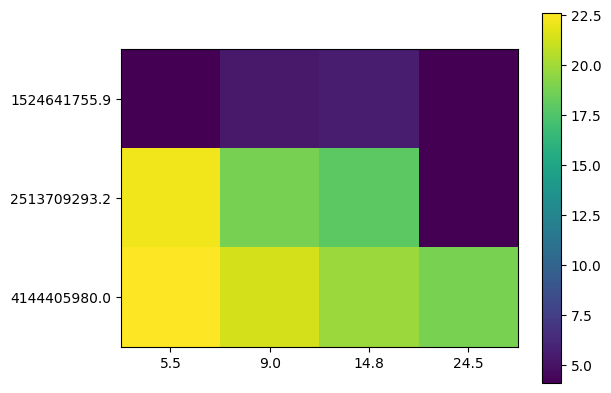

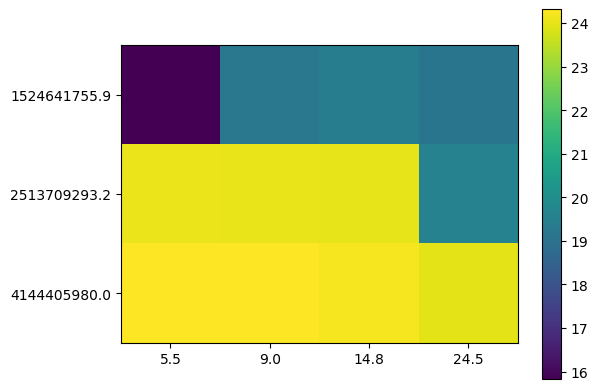

CPU times: user 17h 26min 15s, sys: 19min 8s, total: 17h 45min 24s
Wall time: 5h 16min 5s


In [15]:
%%time
reff_2d = []
density_2d = []
count = 0
for i in uncertainties:
    reff_1d = []
    density_1d = []
    for j in scales:
        count += 1
        print(str(count) + " out of " + str(len(uncertainties)*len(scales)))
        print("------uncertainty", i, "scale", j, "-------")
        reff, density = retrieve(i, j)
        reff_1d.append(reff)
        density_1d.append(density)
    reff_2d.append(reff_1d)
    density_2d.append(density_1d)

rounded_uncertainties = np.round(uncertainties, 1)
rounded_scales = np.round(scales, 1)
img = py.imshow(reff_2d)
py.xticks(np.arange(len(scales)), labels=rounded_scales)
py.yticks(np.arange(len(uncertainties)), labels=rounded_uncertainties)
py.colorbar(img)
py.show()

img = py.imshow(density_2d)
py.xticks(np.arange(len(scales)), labels=rounded_scales)
py.yticks(np.arange(len(uncertainties)), labels=rounded_uncertainties)
py.colorbar(img)
py.show()


In [16]:
reff_2d[1][0]
uncertainties[4]
# scales[2]

IndexError: index 4 is out of bounds for axis 0 with size 3